In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from PIL import Image
from fea.fea2d_mesh import SquareMeshThermal
from fea.fea2d_thermal import ThermalFEM
from fea.project_input import project_input
from fea.boundary import define_boundary_nodes

## Define the domain

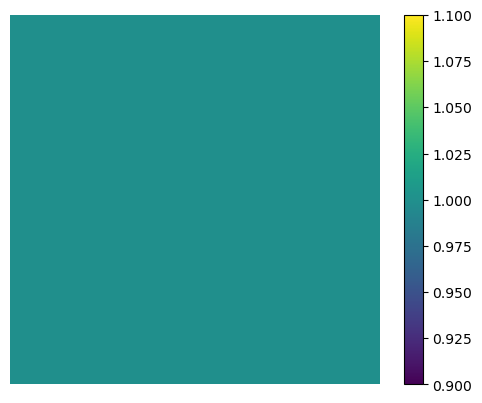

In [2]:
def plot_image(img):
    plt.figure()
    im1 = plt.imshow(img, origin='lower')
    plt.axis('off')
    plt.colorbar(im1)
    
imarray = np.ones((50,50))
plot_image(imarray)

#### Define the loading types

In [3]:
def loading_type1(node_mask, bc):
    '''
    boundary node list: [top, bottom, left, right, curved]

    Loading (0 is x, 1 is y direction): 
    Fix the top boundary, apply random loading at bottom boundary
    '''

    h, w = node_mask.shape
    top_idx = np.where(bc[0][0] == 1)
    bottom_idx = np.where(bc[1][0] == 1)
    left_idx = np.where(bc[2][0] == 1)
    right_idx = np.where(bc[3][0] == 1)
    curved_idx = np.where(bc[4][0] == 1)

    # define dirich boundary (use for FEA and FEA-Net)
    # set top temperature to be 0, bottom to be 2, right to be 1
    dirich_idx = np.zeros((h, w), dtype=np.int32)
    dirich_idx[top_idx[0], top_idx[1]] = 1 # fix at top
    # dirich_idx[bottom_idx[0], bottom_idx[1]] = 1 # fix at bottom
    # dirich_idx[right_idx[0], right_idx[1]] = 1 # fix at right
    dirich_value = np.zeros_like(dirich_idx)
    dirich_value[top_idx[0],top_idx[1]] = 0 
    # dirich_value[bottom_idx[0], bottom_idx[1]] = 2
    # dirich_value[right_idx[0], right_idx[1]] = 1

    dirich_idx_feanet = np.logical_not(dirich_idx).astype(int)
    dirich_idx_feanet *= node_mask

    # define neumann boundary, 1.0 neumann boundary; 0 else
    # set bottom flux to be 2
    traction_idx = np.zeros((h, w), dtype=np.int32)
    traction_value = np.zeros_like(traction_idx)
    traction_idx[bottom_idx[0], bottom_idx[1]] = 1 
    traction_value[bottom_idx[0], bottom_idx[1]] = 2 

    return dirich_idx, dirich_idx_feanet, dirich_value, traction_idx, traction_value

#### Define the problem

In [4]:
hsize = 0.02 # mm
elem_mask = np.copy(imarray)
h, w = elem_mask.shape
material = np.ones((h, w, 1))
material[:,:,0] *= 1 # alpha, thermal coefficient
node_mask = project_input(elem_mask)

# define boundary nodes and connections
bc = define_boundary_nodes(elem_mask) # top(0), bottom(1), left(2), right(3), curved(4)
neumann_connlist = [bc[1][1]] # bottom boundary is neumann
dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val = loading_type1(node_mask, bc)
f_val = np.zeros_like(dirich_val)


In [5]:
# generate a mesh grid
mesh = SquareMeshThermal(hsize, elem_mask, dirich_idx, neumann_connlist, outfile = None)

In [6]:
# generate FEM problem
problem = ThermalFEM(mesh, material, dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1))

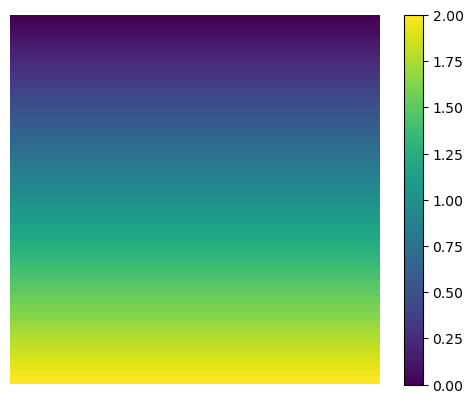

In [7]:
problem.Solve('direct')
problem.PlotField()

#### Post-processing

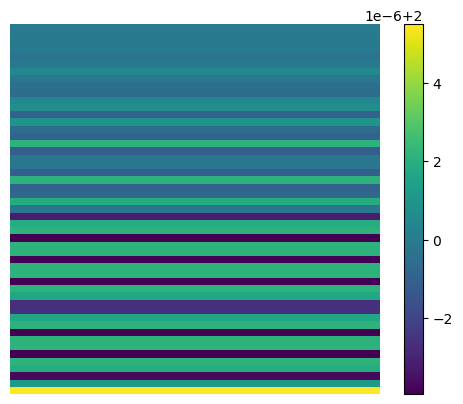

In [8]:
H = problem.ComputeHeatFlux()
problem.PlotField(problem.flux[:,1])

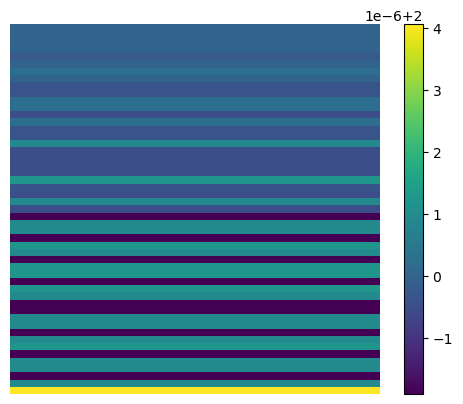

In [9]:
problem.ComputeAverageHeatFlux()
problem.PlotField(problem.flux_avg[:,1])

#### Create dataset

In [10]:
def conn_list2array(node_mask, conn_list):
    '''Convert a connection list into nparrays '''
    h, w = node_mask.shape
    conn_array = np.zeros((h,w,len(conn_list)))
    print(len(conn_list))
    for i in range(len(conn_list)):
        conn_len = conn_list[i].shape[0]
        subarray = np.full((h*w),-1) 
        subarray[:conn_len] = conn_list[i][:,0]
        subarray[conn_len] = conn_list[i][-1,1]
        conn_array[:,:,i] = subarray.reshape((h,w))
    return conn_array
